In [ ]:
#Cài đặt thư viên cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
import matplotlib.pyplot as plt

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv("XRP-USD.csv")
df1=df.reset_index()['Close']

In [ ]:
# 3. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# 4. Xác định đặc trưng dữ liệu
train_features = train_data["Close"].values
train_dates = pd.to_datetime(train_data["Date"])

In [ ]:
# 5. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_features, npart=10)

In [ ]:
# 6. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_features)

In [ ]:
# 7. Dự đoán tập test dựa trên train
test_features = test_data["Close"].values
test_dates = pd.to_datetime(test_data["Date"])
test_predictions = model.predict(test_features)

In [ ]:
# 8. Dự đoán validate dựa trên test
validate_features = val_data["Close"].values
validate_dates = pd.to_datetime(val_data["Date"])
validate_predictions = model.predict(validate_features)

In [ ]:
# 9. Dự đoán 30 ngày tiếp theo dựa trên validate
last_validate_index = len(validate_features) - 1
next_30_days_predictions = []
current_feature = validate_features[last_validate_index]

for _ in range(30):
    prediction = model.forecast([current_feature])[0]
    next_30_days_predictions.append(prediction)
    current_feature = np.array([prediction])

fur_pre = np.array(next_30_days_predictions)


/usr/local/lib/python3.10/dist-packages/pyFTS/common/FuzzySet.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mv = np.array([fuzzy_sets[key].membership(inst) for key in ordered_sets])


In [ ]:
# 10. Đánh giá độ chính xác thuật toán
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
test_mae = mean_absolute_error(test_predictions, test_data['Close'])
test_mape = mean_absolute_percentage_error(test_predictions, test_data['Close'])
test_rmse = np.sqrt(np.mean((test_predictions - test_data['Close'])**2))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(validate_predictions, val_data['Close'])
val_rmse = np.sqrt(np.mean((validate_predictions - val_data['Close'])**2))
val_mape = mean_absolute_percentage_error(validate_predictions, val_data['Close'])
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 0.06018351216133941
Testing RMSE: 0.08240368370544857
Testing MAPE: 0.11098909307524968
Validation MAE: 0.09759085383454104
Validation RMSE: 0.11598139905133947
Validation MAPE: 0.18767726951830263


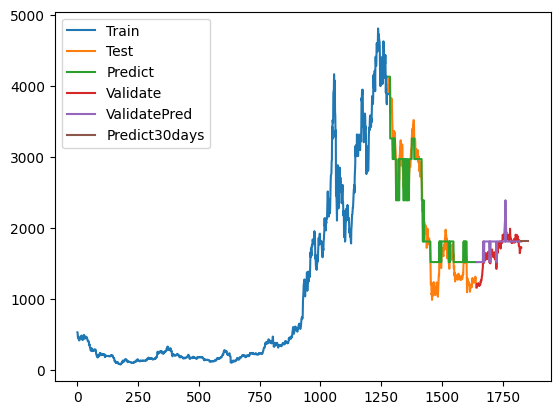

In [ ]:
# 11.Vẽ hình
import matplotlib.pyplot as plt
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot((train_data['Close']))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_data['Close']))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predictions))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(val_data['Close']))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,validate_predictions)

fur_pre_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(fur_pre_index,(fur_pre))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()